In [75]:
import os
import numpy as np
import pandas as pd
import ast
import cv2
import random
import shutil
import yaml

## Prepare OpenPose Dataset To Train YOLOv11 Model

In [76]:
# Assume the generated dataset from a scenario is located here
DATASET_PATH = "../Saved/Datasets/BasicMap_Male_01"

### Load Metadata of All Cameras & Generate Projection Matrices

In [ ]:
def build_camera_projection_matrices(cameras_file):

    camera_data = pd.read_csv(cameras_file)    
    camera_dict = {}
    
    for _, row in camera_data.iterrows():
        # Extracting metadata
        name = row['Name']
        image_height = row['ImageHeight']
        image_width = row['ImageWidth']
        view_projection_matrix = np.array(eval(row['ViewProjectionMatrix']))
        # Store in dictionary along with image dimensions
        camera_dict[name] = {
            'projection_matrix': view_projection_matrix,
            'image_width': image_width,
            'image_height': image_height
        }
    
    return camera_dict


In [78]:
def world_to_pixel_coordinates_with_visibility_check(world_point, camera_info):
    projection_matrix = camera_info['projection_matrix']
    image_width = camera_info['image_width']
    image_height = camera_info['image_height']
    
    # Convert the 3D world point to homogeneous coordinates
    world_point_homogeneous = np.append(world_point, 1)

    # Project the 3D point into the 2D camera space
    clip_space_point = projection_matrix.T @ world_point_homogeneous

    # Perform the perspective divide to get normalized device coordinates (NDC)
    if clip_space_point[3] == 0.0:
        return 0, 0, 0  # Invalid point

    ndc_x = clip_space_point[0] / clip_space_point[3]
    ndc_y = clip_space_point[1] / clip_space_point[3]

    # Convert NDC to screen space coordinates
    pixel_x = int((ndc_x + 1.0) * 0.5 * image_width)
    pixel_y = int((1.0 - ndc_y) * 0.5 * image_height)  # Y-axis is flipped

    # Check if the point is within the image boundaries
    visible = 0 <= pixel_x < image_width and 0 <= pixel_y < image_height

    return pixel_x, pixel_y, int(visible)

In [79]:
camera_metadata_path =  os.path.join(DATASET_PATH, 'Annotations/Cameras.csv')
camera_projection_matrices = build_camera_projection_matrices(camera_metadata_path)

### Handle Projecting Pose Annotation from 3D World Coordinates to 2D Pixel Coordinates

In [80]:
COCOPOSE_LANDMARKS = [
    "Nose", "LEye", "REye", "LEar", "REar",
    "LShoulder", "RShoulder", "LElbow", "RElbow",
    "LWrist", "RWrist", "LHip", "RHip",
    "LKnee", "RKnee", "LAnkle", "RAnkle"
]

COCOPOSE_DEBUG_LINES = [
    ("Nose", "REye", (51, 0, 153)), ("Nose", "LEye", (153, 0, 153)),
    ("REye", "REar", (102, 0, 153)), ("LEye", "LEar", (153, 0, 102)),
    ("REar", "RShoulder", (153, 0, 0)), ("RShoulder", "RElbow", (153, 102, 0)), ("RElbow", "RWrist", (153, 153, 0)),
    ("LEar", "LShoulder", (153, 51, 0)), ("LShoulder", "LElbow", (102, 153, 0)), ("LElbow", "LWrist", (51, 153, 0)),
    ("RShoulder", "RHip", (0, 153, 0)), ("RHip", "RKnee", (0, 153, 51)), ("RKnee", "RAnkle", (0, 153, 102)),
    ("LShoulder", "LHip", (0, 153, 153)), ("LHip", "LKnee", (0, 102, 153)), ("LKnee", "LAnkle", (0, 51, 153))
]

In [81]:
def generate_cocopose_data(file_path, camera_info):
    raw_pose_data = pd.read_csv(file_path)
    pose_data = []
    for index, row in raw_pose_data.iterrows():
        keypoints = {}
        n_visible_keypoints = 0
        for landmark in COCOPOSE_LANDMARKS:
            if landmark in row:
                coords = eval(row[landmark])
                pixel_x, pixel_y, visible =  world_to_pixel_coordinates_with_visibility_check(coords, camera_info)
                n_visible_keypoints += 1 if visible else 0
                keypoints[landmark] = [pixel_x, pixel_y, visible] if visible else [0, 0, 0]
        pose_data.append((keypoints, n_visible_keypoints))
    return pose_data

In [82]:
def draw_preview_poses(image, poses, output_path, min_visible_keypoints=6):
    output = image.copy()
    for (keypoints, n_visible) in poses:
        if n_visible < min_visible_keypoints:
            continue
        for (start, end, color) in COCOPOSE_DEBUG_LINES:
            # check if both keypoints are visible
            if keypoints[start][1] and keypoints[end][1]:
                # todo draw a line between two points
                start_point = (keypoints[start][0], keypoints[start][1])
                end_point = (keypoints[end][0], keypoints[end][1])
                cv2.line(output, start_point, end_point, color, thickness=2)
    cv2.imwrite(output_path, output)

### Handle Projecting Bounding Box Annotation from 3D World Coordinates to 2D Pixel Coordinates

In [83]:
def generate_cocobbox_data(file_path, camera_info):
    # Read the file containing the 3D bounding box annotations
    df = pd.read_csv(file_path)
    
    # List to hold all the 2D bounding boxes
    coco_bboxes = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the 3D bounding box corners
        bbox_3d = []
        for i in range(8):
            # Convert the string representation of the point to a list of floats
            point = ast.literal_eval(row[f'P_{i}'])
            bbox_3d.append(point)
    
        # Initialize lists to hold the 2D projected points
        x_coords = []
        y_coords = []
        projected_3d_bboxes = []
    
        # Project each corner of the 3D bounding box
        for corner in bbox_3d:
            x, y, visible = world_to_pixel_coordinates_with_visibility_check(corner, camera_info)
            projected_3d_bboxes.append((x,y))
            if visible:  # Only consider visible points
                x_coords.append(x)
                y_coords.append(y)
    
        # Check if any points were visible
        if not len(x_coords)>3 or not len(y_coords)>3:
            coco_bboxes.append((0, 0, 0, 0))  # Append a default bounding box if less than 4 points are visible
            continue
    
        # Compute the min and max values to form the bounding box
        x_min = min(x_coords)
        y_min = min(y_coords)
        x_max = max(x_coords)
        y_max = max(y_coords)
    
        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min
    
        # Normalize the bounding box coordinates based on image width and height
        image_width = camera_info['image_width']
        image_height = camera_info['image_height']
        x_min_normalized = x_min / image_width
        y_min_normalized = y_min / image_height
        width_normalized = width / image_width
        height_normalized = height / image_height
    
        # Append the normalized bounding box to the list
        coco_bboxes.append((x_min_normalized, y_min_normalized, width_normalized, height_normalized))
    
    return coco_bboxes, projected_3d_bboxes

In [84]:
def draw_preview_3d_bboxes(image, corners, output_path):
    # Copy the image to avoid modifying the original
    output = image.copy()

    # Define the pairs of corners that make up the 12 edges of a cube
    edges = [
        (0, 1), (1, 3), (3, 2), (2, 0),  # Lower rectangle
        (4, 5), (5, 7), (7, 6), (6, 4),  # Upper rectangle
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical lines
    ]

    # Draw the edges
    for edge in edges:
        start_point = tuple(int(v) for v in corners[edge[0]])
        end_point = tuple(int(v) for v in corners[edge[1]])
        cv2.line(output, start_point, end_point, color=(0, 255, 0), thickness=2)

    # Save the output image
    cv2.imwrite(output_path, output)

In [85]:
def draw_preview_bboxes(image, bboxes, output_path):
    output = image.copy()

    for bbox in bboxes:
        x_min, y_min, width, height = bbox
        
        # Skip bounding boxes with zero width or height
        if width == 0 or height == 0:
            continue

        # Convert normalized coordinates back to pixel coordinates
        image_height, image_width = image.shape[:2]
        x_min_pixel = int(x_min * image_width)
        y_min_pixel = int(y_min * image_height)
        width_pixel = int(width * image_width)
        height_pixel = int(height * image_height)
        
        # Calculate bottom right corner of the bounding box
        x_max_pixel = x_min_pixel + width_pixel
        y_max_pixel = y_min_pixel + height_pixel
        
        # Draw the bounding box on the image
        cv2.rectangle(output, (x_min_pixel, y_min_pixel), (x_max_pixel, y_max_pixel), (0, 255, 0), thickness=2)

    # Save the output image
    cv2.imwrite(output_path, output)

### Generate COCO-Pose Annotation File

In [86]:
def generate_coco_annotation_file(poses, bboxes, image, images_folder_path, labels_folder_path, filename, min_visible_keypoints=2):
    formatted_annotations = []
    image_output_path = os.path.join(images_folder_path, f'{filename}.png')
    label_output_path = os.path.join(labels_folder_path, f'{filename}.txt')
    if not os.path.exists(labels_folder_path):
        os.makedirs(labels_folder_path)
    # save image to images folder
    output_image = image.copy()
    image_height, image_width = output_image.shape[:2]
    if not os.path.exists(images_folder_path):
        os.makedirs(images_folder_path)
    cv2.imwrite(image_output_path, image)
    # save annotation in labels folder
    for index, (keypoints, n_visible) in enumerate(poses):
        if n_visible < min_visible_keypoints:
            continue

        # Start with the category ID, assuming only humans (category ID '0')
        coco_data = ['0']  # Assume we only annotate humans

        # Add bbox data
        coco_data.extend([str(coord) for coord in bboxes[index]])

        # Add keypoint data
        for landmark in COCOPOSE_LANDMARKS:
            if landmark in keypoints:
                coco_visibility = keypoints[landmark][2] * 2  # Scale visibility as specified
                coco_data.extend([
                    str(keypoints[landmark][0]/image_width), 
                    str(keypoints[landmark][1]/image_height), 
                    str(coco_visibility)
                ])
            else:
                coco_data.extend(['0', '0', '0'])  # Default values if keypoint is missing

        # Join data into a single string for this annotation and add to the list
        formatted_annotations.append(' '.join(coco_data))

    # Join all annotations into a single output string with newlines
    output_string = '\n'.join(formatted_annotations)

    # Write the output string to the specified file
    with open(label_output_path, 'w') as file:
        file.write(output_string)

### Additional Utility Functions

In [87]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def plot_random_images(folder_path, num_images=2):
     
    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Ensure there are enough images to sample
    if len(image_files) < num_images:
        print(f"Not enough images in the folder. Found only {len(image_files)} images.")
        return

    # Select `num_images` random images
    random_images = random.sample(image_files, num_images)

    # Load and plot the images
    plt.figure(figsize=(15, 5))  # Set the figure size
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')  # Turn off axis
        plt.title(f"Image {i + 1}")

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()


### Load Images captured from each camera and Generate YOLO-compatible annotation
This will create `Output` folder which contains two sub-folder `images` and `labels` that can be used to train YOLO Pose Estimation

In [88]:
COCOPOSE_OUTPUT_PATH = os.path.join(DATASET_PATH, 'Output')
SAVE_OPENPOSE_PREVIEW = True
SAVE_BBOX_PREVIEW = True
if not os.path.exists(COCOPOSE_OUTPUT_PATH):
    os.makedirs(COCOPOSE_OUTPUT_PATH)

In [89]:
images_folder_path = os.path.join(COCOPOSE_OUTPUT_PATH, 'Full', 'images')
labels_folder_path = os.path.join(COCOPOSE_OUTPUT_PATH, 'Full', 'labels')
pose_annotation_path = os.path.join(DATASET_PATH, 'Annotations/OpenPose3D')
bbox_annotation_path = os.path.join(DATASET_PATH, 'Annotations/BBox3D')

for camera_name, camera_info in camera_projection_matrices.items():
    color_images_path = os.path.join(DATASET_PATH, f'Captures/{camera_name}/Color')
    pose_preview_path = os.path.join(pose_annotation_path, f'Preview/{camera_name}')
    if not os.path.exists(pose_preview_path):
        os.makedirs(pose_preview_path)
    bbox_preview_path = os.path.join(bbox_annotation_path, f'Preview/{camera_name}')
    if not os.path.exists(bbox_preview_path):
        os.makedirs(bbox_preview_path)
    for file_name in os.listdir(color_images_path):
        if file_name.endswith('.png'):
            fname = file_name.split('.')[0]
            # load this color image
            color_image = cv2.imread(os.path.join(color_images_path, file_name))
            # load 3dpose file
            pose_file = os.path.join(pose_annotation_path, f'{fname}.csv')
            coco_poses = generate_cocopose_data(pose_file, camera_info)
            # load 3dbbox file
            bbox_file = os.path.join(bbox_annotation_path, f'{fname}.csv')
            coco_bboxes, projected_3d_bboxes = generate_cocobbox_data(bbox_file, camera_info)
            # generate preview image (optional)
            if SAVE_OPENPOSE_PREVIEW:
                draw_preview_poses(color_image, coco_poses, os.path.join(pose_preview_path, f'{fname}.png'))
            if SAVE_BBOX_PREVIEW:
                draw_preview_3d_bboxes(color_image, projected_3d_bboxes, os.path.join(bbox_preview_path, f'BBox3D_{fname}.png'))
                draw_preview_bboxes(color_image, coco_bboxes, os.path.join(bbox_preview_path, f'BBox2D_{fname}.png'))
            # generate coco annotation for yolo
            coco_filename = f"{camera_name}_{fname}"
            generate_coco_annotation_file(coco_poses, coco_bboxes, color_image, images_folder_path, labels_folder_path, coco_filename)

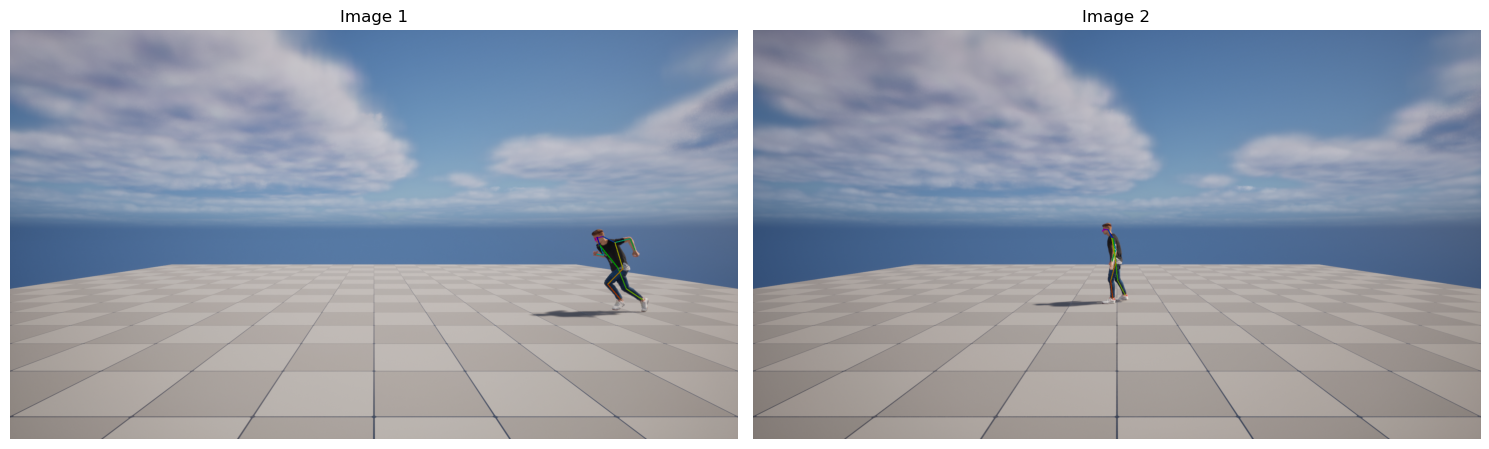

In [70]:
# Display some preview pose images
cam1_pose_preview_path = os.path.join(pose_annotation_path, f'Preview/Cam1')
plot_random_images(pose_preview_path, num_images=2)

In [543]:
# Display some preview bbox images (this folder has both 2D & 3D results
# cam1_bbox_preview_path = os.path.join(bbox_annotation_path, f'Preview/Cam1')
# plot_random_images(cam1_bbox_preview_path, num_images=2)

In [90]:
# Check images files
yolo_image_files = os.listdir(images_folder_path)
print(f"size: {len(yolo_image_files)}")
yolo_image_files[:10]

size: 536


['Cam1_0.png',
 'Cam1_1.png',
 'Cam1_10.png',
 'Cam1_100.png',
 'Cam1_101.png',
 'Cam1_102.png',
 'Cam1_103.png',
 'Cam1_104.png',
 'Cam1_105.png',
 'Cam1_106.png']

In [91]:
# Check labels files
yolo_label_files = os.listdir(labels_folder_path)
print(f"size: {len(yolo_label_files)}")
yolo_label_files[:10]

size: 536


['Cam1_0.txt',
 'Cam1_1.txt',
 'Cam1_10.txt',
 'Cam1_100.txt',
 'Cam1_101.txt',
 'Cam1_102.txt',
 'Cam1_103.txt',
 'Cam1_104.txt',
 'Cam1_105.txt',
 'Cam1_106.txt']

### Create Train & Test Sets

In [92]:
def split_yolo_dataset(images_path, labels_path, output_path, train_ratio=0.8):

    # Create the output directories
    train_images_path = os.path.join(output_path, 'images', 'train')
    val_images_path = os.path.join(output_path, 'images', 'valid')
    train_labels_path = os.path.join(output_path, 'labels', 'train')
    val_labels_path = os.path.join(output_path, 'labels', 'valid')

    os.makedirs(train_images_path, exist_ok=True)
    os.makedirs(val_images_path, exist_ok=True)
    os.makedirs(train_labels_path, exist_ok=True)
    os.makedirs(val_labels_path, exist_ok=True)

    # Get a list of all image files
    image_files = [f for f in os.listdir(images_path) if f.endswith('.png')]

    # Shuffle the files
    random.shuffle(image_files)

    # Split the files into training and validation sets
    split_index = int(len(image_files) * train_ratio)
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]

    # Move the files into the appropriate directories
    for file_name in train_files:
        # Move image file
        shutil.copy(os.path.join(images_path, file_name), os.path.join(train_images_path, file_name))
        # Move corresponding label file
        label_file = file_name.replace('.png', '.txt')
        shutil.copy(os.path.join(labels_path, label_file), os.path.join(train_labels_path, label_file))

    for file_name in val_files:
        # Move image file
        shutil.copy(os.path.join(images_path, file_name), os.path.join(val_images_path, file_name))
        # Move corresponding label file
        label_file = file_name.replace('.png', '.txt')
        shutil.copy(os.path.join(labels_path, label_file), os.path.join(val_labels_path, label_file))

In [93]:
train_val_output_path = os.path.join(DATASET_PATH, 'Output', 'TrainVal')
split_yolo_dataset(images_folder_path, labels_folder_path, train_val_output_path, train_ratio=0.9)

In [548]:
# Check training images files
yolo_image_files = os.listdir(os.path.join(train_val_output_path, 'images','train'))
print(f"size: {len(yolo_image_files)}")
yolo_image_files[:10]

size: 2520


['Cam1_0.png',
 'Cam1_1.png',
 'Cam1_10.png',
 'Cam1_100.png',
 'Cam1_1000.png',
 'Cam1_1001.png',
 'Cam1_1002.png',
 'Cam1_1003.png',
 'Cam1_1004.png',
 'Cam1_1005.png']

In [549]:
# Check validation images files
yolo_image_files = os.listdir(os.path.join(train_val_output_path, 'images','valid'))
print(f"size: {len(yolo_image_files)}")
yolo_image_files[:10]

size: 630


['Cam1_1018.png',
 'Cam1_102.png',
 'Cam1_1021.png',
 'Cam1_1025.png',
 'Cam1_1039.png',
 'Cam1_1047.png',
 'Cam1_1053.png',
 'Cam1_1058.png',
 'Cam1_1064.png',
 'Cam1_1065.png']